# CNN Binary Classification Model

# Section 1 - Introduction & Setup

Suggested model and approach for pointcloud navigation and POI capture using CNN classification.

**Optimization Parameters**  
- Optimization Learning Rate: 1e-3 
- Optimization Momentum: 0.9  

**Data Parameters**  
- Batch Size:2  
- Number of Epochs = 5   
- Image resize = 64

**Sliding Window Parameters**  
- Window Cell Size = 8   
- Window Gap = 2

**Cluster Parameters**  
- Cluster Threshold = 0.7

## 1.1 - Library Imports

In [1]:
## -- PyPlot | Result & Data Visualisation
import matplotlib.pyplot as plt

## -- NumPy | Statistics & Array Manipulation
import numpy as np

## -- Open3D | Pointcloud Visualisation & Interaction
import open3d as open3d

## -- OS | IO/File Sys Interaction
import os

## -- PIL/Image | Image Visualisation & Loading 
from PIL import Image

## -- PyTorch | Core Module, Neural Net, Functional & Optimization libary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## -- Torch Utils | Dataset, DataLoader and random split for dataset setup
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

## -- Torchvision/transforms | Used for base transform of image for model req
from torchvision import transforms

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1.2 - Imports Optional

In [2]:
## -- PacMan Helper | Utility Support Methods [14]
import PacMan_Helper as PacMan

import local_dataset as local_dataset
import local_model as local_model
#import local_training as local_training

## 1.3 - Global Variables

In [3]:
# Base Transform - Used in initial resizing of dataset images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor()  
])

# Model variables
num_epochs = 5
gbl_lr = 1e-3 
gbl_momentum = 0.9

# Sliding Window
gbl_patch_size = 8

# Navigation & clustering
gbl_clusterthresh = 0.7

# Preran model filename
filename="model.pth.tar"

## 1.4: Utility methods

In [14]:
## -- Cluster Thresh ------------------------------------------------------------------------------------------------------
def cluster_thresh(array_coordinates):
    # Determines closest identified cluster based on mean Z value
    array_coordinates = array_coordinates[array_coordinates[:, 2].argsort()]
    clusters = []
    last_z = None
    counter = -1
    
    for coords in array_coordinates:
        if counter==0:
            clusters.append([coords])
            last_z = coords[2]
            
        if last_z is None or abs(coords[2] - last_z) > 1.2:
            #if last_z is not None:
                #print("Cluster change from Z=", last_z, "to Z=", coords[2])
            counter += 1
            clusters.append([coords])
            last_z = coords[2]

    
    n_clusters = len(clusters)
    centroids = [np.mean(c, axis=0) for c in clusters]
    #for idx, centroid in enumerate(centroids, start=1):
        #print("\n", idx, "- Centroid RESULT:", centroid)
        
    if centroids:
        closest_cluster = np.argmin([np.linalg.norm(c) for c in centroids])
        closest_centroid = centroids[closest_cluster]
        return n_clusters, clusters, closest_cluster, closest_centroid
    
## -- Coordinate Check -----------------------------------------------------------------------------------------------------
def coords_check(image, model, device, depth_map, mapx, mapy, mapz, patch_size=8, gap=2):
    
    # Transform for patch/window cell
    patch_transform = transforms.Compose([
        transforms.Resize((patch_size, patch_size)),
        transforms.ToTensor()
    ])

    output_image = np.copy(image)  # Copy of the original image for overlay
    coordinates = []               # 3D coordinates of chosen pixels

    # Sliding window loop
    for i in range(0, image.shape[0]-patch_size+1, gap):
        for j in range(0, image.shape[1]-patch_size+1, gap):
            
            # Patch setup & transform
            patch = image[i:i+patch_size, j:j+patch_size]
            patch_pil = prepare_patch(patch) 
            patch_tensor = patch_transform(patch_pil).unsqueeze(0).to(device)
            
            # Model prediction
            model.eval()
            with torch.no_grad():
                outputs = model(patch_tensor)
                _, predicted = torch.max(outputs, 1)
            
            # Selection filtering
            last_z = 0
            if predicted.item()==1:
                
                output_image[i:i+patch_size, j:j+patch_size, 1] = 255  
                center_i, center_j = i+patch_size//2, j+patch_size//2
                
                
                x = mapx[center_i, center_j]
                y = mapy[center_i, center_j]
                z = mapz[center_i, center_j]
                
                coordinates.append((x, y, z))
                
    return output_image, coordinates

## -- Correct View ------------------------------------------------------------------------------------------------------
def correct_view(angle, check):
    ang_calc2 = angle[1]
    ang_calc2 -= 25
    
    ang_calc3 = angle[1]
    ang_calc3 -= 65
    
    if check==1:
        angle_calc = np.array([angle[0], ang_calc3, angle[2]])
    else:
        angle_calc = np.array([angle[0], ang_calc2, angle[2]])
    return angle_calc 

## -- Prepare patch ----------------------------------------------------------------------------------------------------
def prepare_patch(image_patch):
    if image_patch.dtype!=np.uint8:
        image_patch = np.clip(image_patch*255.0, 0, 255).astype(np.uint8)
    cell = Image.fromarray(image_patch, 'RGB')  
    return cell

# Section 2 - Model initialisation
Load pre-generated model checkpoint as opposed to regenerating fresh model for each run using examples given

## 2.1 - Model initialisation

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")         # Device setup
model = local_model.ClassCNN().to(device)                                     # Model framework setup
optimizer = optim.SGD(model.parameters(), lr=gbl_lr, momentum=gbl_momentum)   # Model optimizer setup
criterion = nn.CrossEntropyLoss()                                             # Model loss/criterion function setup

## 2.2 - Load model

In [6]:
## -- Function to load model -------------------------------------------------------------------------------------------

## -- Load model toggle
load_model_bool = True

## -- Function to load model for current task
def load_model(file, model, optimizer, lr):
    print("Loading model")
    out = torch.load(file, map_location=device)
    model.load_state_dict(out["state_dict"])
    optimizer.load_state_dict(out["optimizer"])

    for group in optimizer.param_groups:
        group["lr"] = lr

if load_model_bool:
    load_model(filename, model, optimizer, gbl_lr)
print("Model successfully loaded!")

Loading model
Model successfully loaded!


# Section 3 - Results | Clustering, navigation & full scene run

## 3.1 - Scene and variables setup

In [7]:
## -- Cloud, position and colour initialisation
global_cloud, spheres_collected = PacMan.startup_scene()

pcd = open3d.geometry.PointCloud(open3d.utility.Vector3dVector(global_cloud['Positions']))
pcd.colors = open3d.utility.Vector3dVector(global_cloud['Colors']/255)

## 3.2 - Full scene run

Uses all defined methods and the model to attempt a full navigation run of the pointcloud scene. Relies on clustering, coordinate and filtering methods ontop of model use.

- def cluster_thresh(array_coordinates)   
- def coords_check(image, model, device, depth_map, mapx, mapy, mapz, patch_size=8, gap=2)   
- def correct_view(angle, check)   
- def prepare_patch(image_patch)   

WARNING - 2024-05-06 04:23:23,504 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


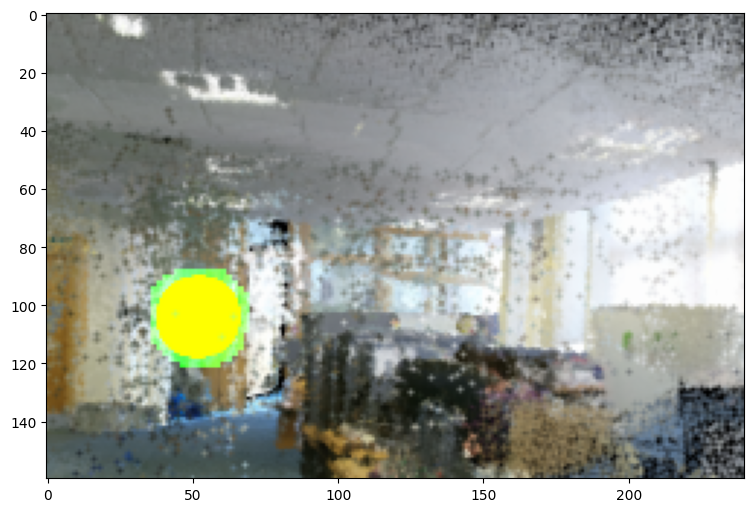


Closest Cluster: 21
Closest Centroid: [-8.94719178  2.03642604  4.50266016]
[True, True, True, True, True, True, True, True, True, True, True]


In [12]:
gbl_angle = np.array([0, 0, 0])     # Initial angle and global variable used
gbl_pos = np.array([0, 0, 0])       # Initial position and global variable used

gbl_resetcount = 0                  # Reset count for any point detection issues
prev_pos = np.array([])             # Previous position store for fallback
stop_check = -1                     # Stop check for checking for new points

## -- Collection loop
while not np.all(spheres_collected):
    count = sum(spheres_collected)
    
    # Capture image & map ---------------------------------------------------------------------------------------------------

    image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, gbl_angle, gbl_pos)

    ## -- Showcase of current capture and coordinate fetch
    output_image, array_coordinates = coords_check(image, model, device, depth, mapx, mapy, mapz)
    array_coordinates = np.array(array_coordinates)
    lencheck = len(array_coordinates)
    if lencheck==0:
        if gbl_resetcount==1:
            gbl_angle = correct_view(gbl_angle, 2)
            gbl_resetcount+=1
            continue
        else:
            gbl_angle = correct_view(gbl_angle, 1)
            gbl_resetcount+=1
            continue
            
    plt.imshow(output_image)
    plt.show()

    # Clustering--------------------------------------------------------------------------------------------------------------

    clusters = []                                                                                    # Initialize cluster array
    n_clusters, clusters, closest_cluster, closest_centroid = cluster_thresh(array_coordinates)      # Clustering returns
    gbl_pos = closest_centroid                                                                       # Update current position

    print("\nClosest Cluster:", closest_cluster)
    print("Closest Centroid:", closest_centroid)

    # Error checking ---------------------------------------------------------------------------------------------------------

    if n_clusters==0 or count==stop_check:
        print("Error! No valid points detected, view adjusting. Calling correct_view()")
        gbl_pos = prev_pos
        stop_check = count
        if gbl_resetcount==1:
            gbl_angle = correct_view(gbl_angle, 2)
            gbl_resetcount+=1
            continue
        else:
            gbl_angle = correct_view(gbl_angle, 1)
            gbl_resetcount+=1
            continue

    ## -- Update scene for point collection, rerun loop
    global_cloud, spheres_collected = PacMan.update_scene(gbl_pos, spheres_collected)
    print(spheres_collected)
    cur = sum(spheres_collected)
    
    if cur==count:
        print("Error! No new points detected, view adjusting. Calling correct_view()")
        gbl_pos = prev_pos
        stop_check = count
        if gbl_resetcount==1:
            gbl_angle = correct_view(gbl_angle, 2)
            gbl_resetcount+=1
            continue
        else:
            gbl_angle = correct_view(gbl_angle, 1)
            gbl_resetcount+=1
            continue
    print("prev pos", prev_pos)        
    prev_pos = gbl_pos
    

## 3.3 - Results

In [13]:
count_true = sum(spheres_collected)
print("Spheres Collected:", count_true, "/11")

Spheres Collected: 11 /11
